# Computing the S isotope fractionation factors for the oxidation of S0 to sulfate by Chlorobaculum tepidum from experimental data

In [1436]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [1437]:
# Import table with data
df_data =  pd.read_csv ('/Users/daniosro/git/MSO/ctep_wt/data/raw/EA/20221114_EA.csv')

#Remove NaN cells
df_data = df_data.dropna(subset=['Identifier'])

# Keep only rows with Peak Nr=3, since Peak Nr=1,2,4 and 5 
# correspond to the reference gas
#Select rows to drop
df_data = df_data[df_data.Peak_Nr == 3]

df_data.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound
2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide
7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide
12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide
17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide
22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide


In [1438]:
df_data[(df_data.Identifier=='b')]

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound
152,b,0.0,1.0,0.0,3,150.9,34.012,1061,32.462,1.550,5061,-2.124,sample,20221221,Sulfide
157,b,28.0,1.0,3.0,3,85.6,9.867,373,9.416,0.450,1781,-2.893,sample,20221221,Sulfide
162,b,43.5,1.0,4.0,3,121.5,20.546,744,19.608,0.939,3559,-2.689,sample,20221221,Sulfide
167,b,70.5,1.0,5.0,3,90.3,8.961,339,8.553,0.408,1614,-5.379,sample,20221221,Sulfide
172,b,121.5,2.0,8.0,3,113.9,11.848,349,11.307,0.540,1665,-2.279,sample,20221221,Sulfate
177,b,210.5,2.0,12.0,3,149.0,42.227,1315,40.301,1.926,6279,-2.048,sample,20221221,Sulfate


Then, let's load the data for the blanks:

In [1439]:
# Import table with the raw data for blanks
df_blanks = pd.read_csv('/Users/daniosro/git/MSO/ctep_wt/data/raw/EA/20221114_blanks.csv')

# Remove rows with missing data
df_blanks.dropna(how='any', inplace=True)

# Keep only rows with Peak Nr=3
df_blanks = df_blanks[df_blanks.Peak_Nr == 3]
df_blanks.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Date
2,blank,3,79.5,3.290,107,3.139,0.151,515,2.001,20221114
7,blank,3,82.5,4.234,143,4.040,0.194,685,3.625,20221114
12,blank,3,80.1,2.722,90,2.598,0.124,431,-2.431,20221114
17,blank,3,78.6,3.675,141,3.508,0.167,670,-5.380,20221114
22,blank,3,82.1,3.687,131,3.516,0.171,636,15.437,20221114


Finally, let's load the data for the linearity test at the beginning of the run:

In [1440]:
# Import file
df_lin =  pd.read_csv('/Users/daniosro/git/MSO/ctep_wt/data/raw/EA/20221114_linearity.csv')
df_lin.head()

,Identifier,Peak_Nr,Width,Ampl_64,Ampl_66,d34S,Date
0,linearity,1,42.6,615,2943,-0.186,20221114
1,linearity,2,48.5,2050,9817,0.000,20221114
2,linearity,3,50.8,3081,14759,0.109,20221114
3,linearity,4,52.5,3733,17882,0.211,20221114
4,linearity,5,55.0,5088,24379,0.406,20221114


Now, let's implement the corrections.

## Blank correction

In [1441]:
# Get the average area all for the blanks

blank_area_all_average = df_blanks.groupby(['Date'], as_index=False)['Area_All'].mean()

# Get the average d34S for the blanks
blank_d34s_average = df_blanks.groupby(['Date'], as_index=False)["d34S"].mean()
blank_d34s_average

,Date,d34S
0,20221114,2.221
1,20221221,-2.325


In [1442]:
#Apply correction by blank

# Initialize list to save values
Correction_of_d34S_blank = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Extract date
    Date = row.Date
    # Extract area and d34S
    area = blank_area_all_average[blank_area_all_average.Date == Date].Area_All.iloc[0]
    delta = blank_d34s_average[blank_d34s_average.Date == Date].d34S.iloc[0]
    product_sample = row.Area_All*row.d34S
    product_blank = area*delta
    product_sub = product_sample-product_blank
    blank_substraction=row.Area_All-area
    Correction_of_d34S_blank.append(product_sub/blank_substraction)
    
# Append values to dataframe
df_data['Correction_of_d34S_blank'] = Correction_of_d34S_blank

df_data.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank
2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide,-2.576618
7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide,-2.233149
12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide,-3.215737
17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide,-1.902086
22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide,-3.471521


## Linearity correction

In [1443]:
# Create variables for linear regression
# x will be the amplitude of the peak of mass 64 = ^32S + ^16O + ^16O
# We divided by 1000 to convert volts ot milivolts
# Get the slope and intercept for the standards of each group
#Group by date
df_lingroup = df_lin.groupby (['Date'])

# Define column names
names = ['Date', 'R squared', 'Intercept', 'Slope']

# Initialize empty dataframe to save fit results
df_linreg_date = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#Loop through standard groups                       
for group, data in enumerate (df_lingroup):
    #x will be the values of Ampl64
    x_std = data[1].Ampl_64.values.reshape((-1,1))
    #y will be the values of d34S 
    y_std = data[1].d34S
    # Create model
    model = LinearRegression().fit(x_std,y_std)
    #Determine R square, intercept and slope
    r_sq_stds = model.score(x_std,y_std)
    intercept_stds = model.intercept_
    s1 = model.coef_
    slope_stds = s1[0]
    # Store parameters and group as list
    params = (data[1].Date.unique(), r_sq_stds, intercept_stds, slope_stds)
 
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg_date = df_linreg_date.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places    
df_linreg_date 

,Date,R squared,Intercept,Slope
0,[20221114],0.923981,-0.208022,0.000102
1,[20221221],0.919539,-0.290615,0.000162


In [1444]:
#Apply corrections by amplitude

# Initialize lists to save values
Correction_of_d34S_by_amplitude = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Calculate an amplitude difference by centering around an arbitrary 
    # value in the Ampl_64 column of the data dataframe  
    num= np.subtract(row.Ampl_64, 800)
    ampl_difference = np.divide (num, 1000)
    # Extract date
    Date = row.Date
    # Extract slope and intercept
    slope = df_linreg_date[df_linreg_date.Date == Date].Slope.iloc[0]
    intercept = df_linreg_date[df_linreg_date.Date == Date].Intercept.iloc[0]
    # Compute the amplitude correction factor
    ampl_correction_factor = intercept + slope * ampl_difference
    # Compute corrected d34S by amplitude 
    Correction_of_d34S_by_amplitude.append(row.Correction_of_d34S_blank-ampl_correction_factor)
    
# Append values to dataframe
df_data['Correction_of_d34S_by_amplitude'] = Correction_of_d34S_by_amplitude

df_data.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude
2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide,-2.576618,-2.286220
7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide,-2.233149,-1.942773
12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide,-3.215737,-3.007681
17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide,-1.902086,-1.611474
22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide,-3.471521,-3.263475


## Standard correction 

First, let's create a category column in the dataframe according to the size of the area of the peak of each sample and standard.

In [1445]:
# Correct each sample by standards with similar areas

#Create standard correction group empty list
Std_group = []
# Classify the area of the samples by category 
# Loop through dataframe rows
for row in df_data['Area_All']:
    if row <= 22:
        Std_group.append ('low')
    else:
        Std_group.append ('high')
# Append to data dataframe 
df_data['Std_group'] = Std_group
df_data.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide,-2.576618,-2.286220,high
7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide,-2.233149,-1.942773,high
12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide,-3.215737,-3.007681,low
17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide,-1.902086,-1.611474,high
22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide,-3.471521,-3.263475,low


In [1446]:
# Create df with only standard data
df_standards = df_data[(df_data.Type == 'standard')] 
#Sort values by ID and area
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])
#Remove SW
df_standards = df_standards[(df_standards.Identifier != 'SW')] 

df_standards.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
97,AGS-2,NaN,NaN,NaN,3,124.3,19.531,571,18.639,0.892,2730,0.020,standard,20221114,NaN,-0.412430,-0.204384,low
122,AGS-2,NaN,NaN,NaN,3,102.1,21.084,784,20.119,0.965,3758,1.155,standard,20221221,NaN,1.930904,2.221522,low
147,AGS-2,NaN,NaN,NaN,3,121.5,21.801,751,20.804,0.997,3595,0.770,standard,20221221,NaN,1.432511,1.723134,low
137,AGS-2,NaN,NaN,NaN,3,119.6,29.694,1063,28.335,1.359,5094,0.717,standard,20221221,NaN,1.169341,1.459914,high
112,AGS-2,NaN,NaN,NaN,3,130.6,31.752,881,30.299,1.453,4219,1.734,standard,20221114,NaN,1.679283,1.887297,high


In [1447]:
#Drop outliers in place
df_standards.drop(df_standards.index[30], inplace=True)
df_standards.drop(df_standards.index[15], inplace=True)
df_standards.drop(df_standards.index[6], inplace=True)
df_standards.drop(df_standards.index[0], inplace=True)

# Calculate the slope and intercept for calculated vs. true value of the stds

# Append true value column to the standard table
# For AGS2
df_standards.loc[df_standards['Identifier'] \
                  == 'AGS-2', 'True_d34S'] = 1.89
# For SID-9
df_standards.loc[df_standards['Identifier'] \
                  == 'SID-9', 'True_d34S'] = -9.55
                       
# Group by Std_group
df_stdgroup = df_standards.groupby (['Std_group'])

df_standards.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,True_d34S
122,AGS-2,NaN,NaN,NaN,3,102.1,21.084,784,20.119,0.965,3758,1.155,standard,20221221,NaN,1.930904,2.221522,low,1.89
147,AGS-2,NaN,NaN,NaN,3,121.5,21.801,751,20.804,0.997,3595,0.770,standard,20221221,NaN,1.432511,1.723134,low,1.89
137,AGS-2,NaN,NaN,NaN,3,119.6,29.694,1063,28.335,1.359,5094,0.717,standard,20221221,NaN,1.169341,1.459914,high,1.89
112,AGS-2,NaN,NaN,NaN,3,130.6,31.752,881,30.299,1.453,4219,1.734,standard,20221114,NaN,1.679283,1.887297,high,1.89
102,AGS-2,NaN,NaN,NaN,3,150.3,32.447,1042,30.962,1.485,4991,2.122,standard,20221114,NaN,2.111141,2.319139,high,1.89


Below, we make a linear regression for the standards of each area group.

In [1448]:
# Get the slope and intercept for the standards of each group
# Define column names
names = ['Std_group', 'R squared', 'Intercept', 'Slope']

# Initialize empty dataframe to save fit results
df_linreg_stds = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#Loop through standard groups                       
for group, data in enumerate (df_stdgroup):
    #x will be the values of d34S of the stds corrected by blanks and linearity
    x_std = data[1].Correction_of_d34S_by_amplitude.values.reshape((-1,1))
    #y will be the true values of d34S of each standard
    y_std = data[1].True_d34S
    # Create model
    model = LinearRegression().fit(x_std,y_std)
    #Determine R square, intercept and slope
    r_sq_stds = model.score(x_std,y_std)
    intercept_stds = model.intercept_
    s1 = model.coef_
    slope_stds = s1[0]
    # Store parameters and group as list
    params = (data[1].Std_group.unique(), r_sq_stds, intercept_stds, slope_stds)
 
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg_stds = df_linreg_stds.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places
df_linreg_stds = df_linreg_stds.round(2)     
df_linreg_stds 

,Std_group,R squared,Intercept,Slope
0,[high],1.0,-0.19,1.00
1,[low],1.0,0.03,0.94


Finally, let's apply the standard correction to the samples based on their area:

In [1449]:
#Apply corrections by true value and area

# Initialize lists to save values
slopes = []
intercepts = []
Correction_of_d34S_by_true_value = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Extract standard group
    Std_group = row.Std_group
    # Extract slope and intercept
    slope = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Slope.iloc[0]
    intercept = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Intercept.iloc[0]
    slopes.append(slope)
    intercepts.append(intercept)
    # Compute corrected concentration
    Correction_of_d34S_by_true_value.append(intercept + slope * row.Correction_of_d34S_by_amplitude)
    
# Append values to dataframe
df_data['Correction_of_d34S_by_true_value'] = Correction_of_d34S_by_true_value

df_data.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide,-2.576618,-2.286220,high,-2.476220
7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide,-2.233149,-1.942773,high,-2.132773
12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide,-3.215737,-3.007681,low,-2.797220
17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide,-1.902086,-1.611474,high,-1.801474
22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide,-3.471521,-3.263475,low,-3.037666


Since all the corrections have been done, we will now export the corrected data, which must be combined with the quantification data to get the plots of sulfide degradation and change in the $\delta^{34}S$ of the remaining sulfide as a function of time or -ln of sulfide remaining.

In [1450]:
# Create dataframe that includes only data from the samples
df_samples = df_data[(df_data.Type == 'sample')]

# Export data table
df_samples.to_csv('/Users/daniosro/git/MSO/ctep_wt/data/processed/EA/20221114_EA.csv')

df_samples.head()

,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide,-2.576618,-2.286220,high,-2.476220
7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide,-2.233149,-1.942773,high,-2.132773
12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide,-3.215737,-3.007681,low,-2.797220
17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide,-1.902086,-1.611474,high,-1.801474
22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide,-3.471521,-3.263475,low,-3.037666


### Analytical repeatability of measurements

Let's calculate the analytical repeatability of the EA-IRMS measurements. 

In [1451]:
# Update standard df
# Create a dataframe for only standards from the updated data dataframe
df_standards = df_data[(df_data.Type == 'standard')]
df_standards
#Drop outliers in place
df_standards.drop(df_standards.index[30], inplace=True)
df_standards.drop(df_standards.index[15], inplace=True)
df_standards.drop(df_standards.index[6], inplace=True)
df_standards.drop(df_standards.index[0], inplace=True)

In [1452]:
#Sort values
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

#Group standards by identifier, area and date
grouped_standards = df_standards.groupby(['Identifier', 'Std_group','Date'])

# Determine the mean of each standard  and rename the series
mean_stds = grouped_standards['Correction_of_d34S_by_true_value'].mean()
mean_stds = mean_stds.rename("d34S_mean")

# Determine the standard deviation of each standard  and rename the series
std_dev_stds = grouped_standards['Correction_of_d34S_by_true_value'].std()
std_dev_stds = std_dev_stds.rename("d34S_stdev")

#Pass series to individual dataframes
df_mean_stds=mean_stds.to_frame()
df_std_dev_stds=std_dev_stds.to_frame()


In [1453]:
#merge the mean and standard deviation dataframes
df_anrep = pd.merge(df_mean_stds, df_std_dev_stds,  how='outer', on=['Identifier', 'Std_group','Date'])

#Reset index of the dataframe
df_anrep = df_anrep.reset_index()

#Add column of true value of the standards
df_anrep.loc[df_anrep['Identifier'] \
                  == 'AGS-2', 'True_d34S'] = 1.89
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SID-9', 'True_d34S'] = -9.55

#Determine the accuracy by subtracting the true value from the average value of each standard
df_anrep ['Accuracy'] = abs(df_anrep ['True_d34S'] - df_anrep ['d34S_mean'])
df_anrep

,Identifier,Std_group,Date,d34S_mean,d34S_stdev,True_d34S,Accuracy
0,AGS-2,high,20221114,1.700236,0.473194,1.89,0.189764
1,AGS-2,high,20221221,1.722521,0.322837,1.89,0.167479
2,AGS-2,low,20221114,-0.162121,NaN,1.89,2.052121
3,AGS-2,low,20221221,1.883989,0.331269,1.89,0.006011
4,SID-9,high,20221114,-9.371445,0.561876,-9.55,0.178555
5,SID-9,high,20221221,-9.379463,0.846334,-9.55,0.170537
6,SID-9,low,20221114,-9.516394,0.127922,-9.55,0.033606
7,SW,high,20221114,21.181096,0.390539,NaN,NaN
8,SW,high,20221221,21.535636,0.355327,NaN,NaN


## Import the quantification data and calculate the fraction of sulfide and sulfate produced

Let's begin by loading the sulfate quantification data (ion chromatography):

In [1454]:
# Import table with data
df_concs =  pd.read_csv ('/Users/daniosro/git/MSO/ctep_wt/data/raw/ICS/20221114_IC.csv')
df_concs_sulfide = df_concs[(df_concs.Compound == 'Sulfide')]
df_concs_sulfate = df_concs[(df_concs.Compound == 'Sulfate')]
df_concs.head()

,ID,Replicate,Timepoint,Time_h,well,Compound,Conc_uM
0,a,1,0,0.0,1,Sulfide,3.745201
1,a,1,0,0.0,2,Sulfide,3.789050
2,a,1,0,0.0,3,Sulfide,3.156561
3,a,1,1,7.0,1,Sulfide,3.519538
4,a,1,3,28.0,1,Sulfide,1.625472


In [1455]:
df_concs_sulfide.head()

,ID,Replicate,Timepoint,Time_h,well,Compound,Conc_uM
0,a,1,0,0.0,1,Sulfide,3.745201
1,a,1,0,0.0,2,Sulfide,3.789050
2,a,1,0,0.0,3,Sulfide,3.156561
3,a,1,1,7.0,1,Sulfide,3.519538
4,a,1,3,28.0,1,Sulfide,1.625472


In [1456]:
#Get average concentrations of the three wells for each replicate
df_concs_sulfide['avg_conc'] = df_concs_sulfide.groupby(['ID','Replicate','Time_h'])['Conc_uM'].transform(mean)
df_concs_sulfide.head()

,ID,Replicate,Timepoint,Time_h,well,Compound,Conc_uM,avg_conc
0,a,1,0,0.0,1,Sulfide,3.745201,3.563604
1,a,1,0,0.0,2,Sulfide,3.789050,3.563604
2,a,1,0,0.0,3,Sulfide,3.156561,3.563604
3,a,1,1,7.0,1,Sulfide,3.519538,3.519538
4,a,1,3,28.0,1,Sulfide,1.625472,1.432088


The only correction made was by the dilution factor. The machine software calculated the concentration in each sample vial based on the standards.

We will calculate the fraction of reactant remaining for each replicate at each time point:

In [1457]:
#Create ID column with the combination of treatment, time and replicate
df_concs_sulfide['Identifier'] = df_concs_sulfide['ID'] + '_' +\
df_concs_sulfide['Time_h'].astype(int).map(str) + '_' + \
df_concs_sulfide['Replicate'].map(str)

# Get the max values for concentration for each treatment and replicate and 
# append it to a new column
df_concs_sulfide['max_conc'] = \
df_concs_sulfide.groupby(['ID','Replicate'])['avg_conc'].transform(max)

# Get the fraction of reactant remaining for each time point
df_concs_sulfide['f_R'] = abs(np.divide(df_concs_sulfide['avg_conc'], \
               df_concs_sulfide['max_conc']))

# Remove duplicates
df_concs_sulfide = df_concs_sulfide.drop_duplicates(subset ="Identifier")

df_concs_sulfide.head()

,ID,Replicate,Timepoint,Time_h,well,Compound,Conc_uM,avg_conc,Identifier,max_conc,f_R
0,a,1,0,0.0,1,Sulfide,3.745201,3.563604,a_0_1,3.563604,1.000000
3,a,1,1,7.0,1,Sulfide,3.519538,3.519538,a_7_1,3.563604,0.987634
4,a,1,3,28.0,1,Sulfide,1.625472,1.432088,a_28_1,3.563604,0.401865
7,a,1,4,43.5,1,Sulfide,1.077860,1.156214,a_43_1,3.563604,0.324451
10,a,1,5,70.5,1,Sulfide,0.302694,0.296826,a_70_1,3.563604,0.083294


In [1458]:
#Create ID column with the combination of treatment, time and replicate
df_concs_sulfate['Identifier'] = df_concs_sulfate['ID'] + '_' +\
df_concs_sulfate['Time_h'].astype(int).map(str) + '_' + \
df_concs_sulfate['Replicate'].map(str)

# Get the max values for concentration for each treatment and replicate and 
# append it to a new column
df_concs_sulfate['max_conc'] = \
df_concs_sulfate.groupby(['ID','Replicate'])['Conc_uM'].transform(max)

# Get the fraction of reactant remaining for each time point
df_concs_sulfate['f_R'] = 1-(abs(np.divide(df_concs_sulfate['Conc_uM'], \
               df_concs_sulfate['max_conc'])))

# Remove duplicates
df_concs_sulfate = df_concs_sulfate.drop_duplicates(subset ="Identifier")

df_concs_sulfate.head()

,ID,Replicate,Timepoint,Time_h,well,Compound,Conc_uM,Identifier,max_conc,f_R
6,a,1,4,43.5,1,Sulfate,15.786712,a_43_1,1406.598064,0.988777
9,a,1,5,70.5,1,Sulfate,0.000000,a_70_1,1406.598064,1.000000
12,a,1,6,91.0,1,Sulfate,264.955007,a_91_1,1406.598064,0.811634
15,a,1,7,101.5,1,Sulfate,422.065093,a_101_1,1406.598064,0.699939
16,a,1,8,121.5,1,Sulfate,765.060854,a_121_1,1406.598064,0.456091


In [1459]:
# Export data tables
df_concs_sulfide.to_csv(f'{homedir}/ctep_wt/data/processed/ICS/20221114_sulfide_cline.csv') 
df_concs_sulfate.to_csv(f'{homedir}/ctep_wt/data/processed/ICS/20221114_sulfate_ic.csv')

## Create master table

Now, let's create a table to compile the corrected values from EA-IRMS and quantification of sulfide by Cline assay and sulfate by ion chromatography. We will begin by loading the processed EA data and dropping the non-needed columns:

In [1460]:
# Import tables with the EA processed data
df_ea_1 = pd.read_csv(f'{homedir}/ctep_wt/data/processed/EA/20221114_EA.csv')
df_ea_1.head()

,Unnamed: 0,Identifier,Time_h,Replicate,Timepoint,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Compound,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
0,2,a,0.0,1.0,0.0,3,166.1,66.163,2146,63.151,3.012,10226,-2.562,sample,20221221,Sulfide,-2.576618,-2.286220,high,-2.476220
1,7,a,0.0,1.0,0.0,3,152.7,60.341,2279,57.593,2.748,10866,-2.239,sample,20221221,Sulfide,-2.233149,-1.942773,high,-2.132773
2,12,a,28.0,1.0,3.0,3,128.6,16.438,471,15.687,0.751,2253,-2.155,sample,20221114,Sulfide,-3.215737,-3.007681,low,-2.797220
3,17,a,28.0,1.0,3.0,3,116.4,22.924,817,21.876,1.048,3911,-1.973,sample,20221221,Sulfide,-1.902086,-1.611474,high,-1.801474
4,22,a,43.5,1.0,4.0,3,122.5,17.070,557,16.292,0.778,2659,-2.402,sample,20221114,Sulfide,-3.471521,-3.263475,low,-3.037666


In [1461]:
# Create empty master dataframe
df_master=pd.DataFrame()

# Fill master table
df_master['treatment'] = df_ea_1['Identifier']
df_master['d34S_raw'] = df_ea_1['d34S']
df_master['Area_All'] = df_ea_1['Area_All']
df_master['d34S_corrected'] = df_ea_1['Correction_of_d34S_by_true_value']
df_master['replicate'] = df_ea_1['Replicate'].astype(int)
df_master['Compound'] = df_ea_1['Compound']
df_master['time_h'] = (df_ea_1['Time_h']).astype(int)

#Create new ID column with the combination of enzyme, time and date
df_master['Identifier'] = df_master['treatment'] + '_' +\
df_master['time_h'].map(str) + '_' + df_master['replicate'].map(str)

# Sort values
df_master = df_master.sort_values(['treatment', 'time_h', 'Identifier'])

#Create master dataframe for sulfide only
df_sulfide_master = df_master[(df_master.Compound == 'Sulfide')]
#Create master dataframe for sulfate only
df_sulfate_master = df_master[(df_master.Compound == 'Sulfate')]

Now, we will fuse this table with the quantification by ion chromatography table:

In [1462]:
# Append f_r (fraction of reactant remaining) column to the sulfide master table
df_sulfide_master = df_sulfide_master.merge(df_concs_sulfide.filter(['Identifier', 'f_R']), how='left',
                 left_on='Identifier', right_on='Identifier')
#Substitute zeroes by a very small non-zero value in the 1-f_R column to be able to calculate
#the reg line
df_sulfide_master['f_R'] = df_sulfide_master['f_R'].replace(0, 0.0001)
# Append -ln(f_r) column to the master table
df_sulfide_master['minus_ln_f_R'] = abs(-np.log(df_sulfide_master['f_R']))

df_sulfide_master.head()

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,minus_ln_f_R
0,a,-2.562,66.163,-2.476220,1,Sulfide,0,a_0_1,1.000000,0.000000
1,a,-2.239,60.341,-2.132773,1,Sulfide,0,a_0_1,1.000000,0.000000
2,a,-2.155,16.438,-2.797220,1,Sulfide,28,a_28_1,0.401865,0.911639
3,a,-1.973,22.924,-1.801474,1,Sulfide,28,a_28_1,0.401865,0.911639
4,a,-2.402,17.070,-3.037666,1,Sulfide,43,a_43_1,0.324451,1.125621


## Fractionation factor from sulfide to S(0)

To determine the fractionation factor $^{34}\varepsilon$, we will use a linearized form of the Rayleigh distillation equation (Mariotti et al., 1981; Scott et al., 2014):

$$
ln (^{34}\delta_{S^{-2}} +1) = ln (^{34}\delta_{S^{-2},0} +1) + {^{34}\varepsilon} \cdot ln f,
$$ 

where $^{34}\delta_{S^{-2}}$ is the delta value for 34/32 S for sulfide at any given point, $^{34}\delta_{S^{-2},0}$ is the delta value for 34/32 S for sulfide at t = 0, ${^{34}\varepsilon}$ is the fractionation factor of 34/32 S in the sulfide oxidation reaction and f is the fraction of sulfide remaining at the point where $^{34}\delta_{S^{-2}}$ is measured. We will append a column corresponding to $ln (^{34}\delta_{S^{-2}} +1)$ to the dataframe.

In [1463]:
#Calculate the ln (delta_sulfide+1) and append to dataframe
#Filter by sulfide

df_sulfide_master['d34S_sulfide'] = 1000*np.log(df_sulfide_master['d34S_corrected']/1000+1)

#Show dataframe
df_sulfide_master.head()

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,minus_ln_f_R,d34S_sulfide
0,a,-2.562,66.163,-2.476220,1,Sulfide,0,a_0_1,1.000000,0.000000,-2.479291
1,a,-2.239,60.341,-2.132773,1,Sulfide,0,a_0_1,1.000000,0.000000,-2.135050
2,a,-2.155,16.438,-2.797220,1,Sulfide,28,a_28_1,0.401865,0.911639,-2.801140
3,a,-1.973,22.924,-1.801474,1,Sulfide,28,a_28_1,0.401865,0.911639,-1.803098
4,a,-2.402,17.070,-3.037666,1,Sulfide,43,a_43_1,0.324451,1.125621,-3.042289


In [1464]:
# Export master table with the data with all corrections

df_sulfide_master.to_csv(f'{homedir}/ctep_wt/data/processed/EA_cline/20221114_EA_cline.csv')

# Calculate $\epsilon$ for sulfide to S(0)

In [1465]:
# Get the slope and intercept for each treatment

df_linreg = df_sulfide_master.groupby(['treatment']).apply(
        lambda g: (((LinearRegression().fit((g.minus_ln_f_R.values).\
                                      reshape((-1,1)), g.d34S_sulfide.values)\
.coef_[0], LinearRegression().fit((g.minus_ln_f_R.values).reshape((-1,1)), \
                         g.d34S_sulfide.values).intercept_, LinearRegression().\
                     fit((g.minus_ln_f_R.values).reshape((-1,1)), g.d34S_sulfide.values).\
                     score((g.minus_ln_f_R.values).reshape((-1,1)), g.d34S_sulfide.values)\
                         )))).apply(pd.Series)\
.rename(columns={0:'slope', 1:'intercept', 2: 'R_squared'}).reset_index()

# Assign name as the index column
#df_100 =df_100.round(2)
df_linreg

,treatment,slope,intercept,R_squared
0,a,-1.252496,-1.829514,0.824074
1,aa,-1.422241,-0.485897,0.575375
2,aaa,-1.551993,-1.734126,0.804738
3,b,-1.203948,-1.603479,0.961657
4,e,-1.637632,-1.647535,0.938099
5,full,-0.945498,-2.185345,0.702026


# Plot of the isotope data

In [1466]:
df_sulfide_master.head()

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,minus_ln_f_R,d34S_sulfide
0,a,-2.562,66.163,-2.476220,1,Sulfide,0,a_0_1,1.000000,0.000000,-2.479291
1,a,-2.239,60.341,-2.132773,1,Sulfide,0,a_0_1,1.000000,0.000000,-2.135050
2,a,-2.155,16.438,-2.797220,1,Sulfide,28,a_28_1,0.401865,0.911639,-2.801140
3,a,-1.973,22.924,-1.801474,1,Sulfide,28,a_28_1,0.401865,0.911639,-1.803098
4,a,-2.402,17.070,-3.037666,1,Sulfide,43,a_43_1,0.324451,1.125621,-3.042289


In [1467]:
df_sulfide_master[(df_sulfide_master.treatment=='b')]

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,minus_ln_f_R,d34S_sulfide
15,b,-2.124,34.012,-1.997816,1,Sulfide,0,b_0_1,1.000000,0.000000,-1.999815
16,b,-2.893,9.867,-2.756917,1,Sulfide,28,b_28_1,0.417637,0.873142,-2.760724
17,b,-2.689,20.546,-2.303219,1,Sulfide,43,b_43_1,0.324982,1.123985,-2.305875
18,b,-5.379,8.961,-6.909465,1,Sulfide,70,b_70_1,0.013518,4.303762,-6.933446


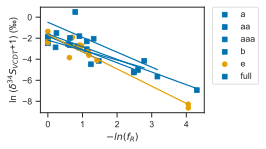

In [1468]:
# Define colors
colors = ('#0072B2', '#0072B2', '#0072B2', '#0072B2', '#E69F00', '#0072B2')
#colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['s', 's', 's','s','o','s']
# Group by tratment
df_group = df_sulfide_master.groupby(['treatment'])

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    #Calculate trendline  
    z = np.polyfit(data.minus_ln_f_R, data.d34S_sulfide, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.minus_ln_f_R, p(data.minus_ln_f_R), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.minus_ln_f_R, data.d34S_sulfide, color=colors[i], marker=markers[i],
              label = group)
    #ax.set_title('DddY')
    ax.set_xlabel('$-ln (f_R)$')
    ax.set_ylabel('ln ($\delta{}^{34}S_{VCDT}$+1) (‰)')
    #ax.set_ylim(14,19,1)

#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#Save figure
#fig.savefig(f'{homedir}/ctep_wt/figures/ctepwt_fr_sulfide_dark.pdf', bbox_inches='tight')

# Calculate $\epsilon$ for S(0) to sulfate

To determine the fractionation factor $^{34}\varepsilon$, we will use a linearized form of the Rayleigh distillation equation (Mariotti et al., 1981; Scott et al., 2014):

$$
ln (^{34}\delta{(SO_4^{-2})} +1) = ln (^{34}\delta{(S^{-2})_0} +1) + {^{34}\varepsilon} \cdot (f \cdot ln f)/(1-f),
$$ 

where $^{34}\delta{(SO_4^{-2})}$ is the delta value for 34/32 S for the produced sulfate at any given point, $^{34}\delta{(S^{-2})_0}$ is the delta value for 34/32 S for sulfide at t = 0, ${^{34}\varepsilon}$ is the fractionation factor of 34/32 S in the oxidation reaction from elemental sulfur to sulfate and f is the fraction of reactant (elemental sulfur or sulfide) remaining at the point where $^{34}\delta{(SO_4^{-2}})$ is measured. We will append a column corresponding to $ln (^{34}\delta{(SO_4^{-2}}) +1)$ to the dataframe.

In [1469]:
# Append f_r (fraction of reactant remaining) column to the sulfate master table
df_sulfate_master = df_sulfate_master.merge(df_concs_sulfate.filter(['Identifier', 'f_R']), how='left',
                 left_on='Identifier', right_on='Identifier')
df_sulfate_master
#Substitute zeroes by a very small non-zero value in the 1-f_R column to be able to calculate
#the reg line
df_sulfate_master['f_R'] = df_sulfate_master['f_R'].replace(0, 0.0001)# Append f_r.ln(f_r)/(1-f_r) column to the master table

# Append f_r.ln(f_r)/(1-f_r) column to the master table
oneminus_f_r = 1-df_sulfate_master['f_R']
df_sulfate_master['xaxis_linreg'] = ((np.log(df_sulfate_master['f_R']))*df_sulfate_master['f_R'])/oneminus_f_r

#Calculate the ln (delta_sulfate+1) and append to dataframe
df_sulfate_master['d34S_sulfate'] = 1000*np.log(df_sulfate_master['d34S_corrected']/1000+1)

#Show dataframe
df_sulfate_master.head()

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,xaxis_linreg,d34S_sulfate
0,a,-0.552,122.167,-0.609056,1,Sulfate,91,a_91_1,0.811634,-0.899274,-0.609241
1,a,-0.678,21.197,-0.897585,2,Sulfate,91,a_91_2,0.676111,-0.817034,-0.897988
2,a,-0.713,63.421,-0.851381,1,Sulfate,121,a_121_1,0.456091,-0.658309,-0.851743
3,a,-0.811,32.060,-1.130018,2,Sulfate,121,a_121_2,0.423853,-0.631475,-1.130657
4,a,-0.812,31.452,-1.138373,1,Sulfate,144,a_144_1,0.370734,-0.584599,-1.139021


In [1470]:
df_sulfate_master

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,xaxis_linreg,d34S_sulfate
0,a,-0.552,122.167,-0.609056,1,Sulfate,91,a_91_1,0.811634,-0.899274,-0.609241
1,a,-0.678,21.197,-0.897585,2,Sulfate,91,a_91_2,0.676111,-0.817034,-0.897988
2,a,-0.713,63.421,-0.851381,1,Sulfate,121,a_121_1,0.456091,-0.658309,-0.851743
3,a,-0.811,32.060,-1.130018,2,Sulfate,121,a_121_2,0.423853,-0.631475,-1.130657
4,a,-0.812,31.452,-1.138373,1,Sulfate,144,a_144_1,0.370734,-0.584599,-1.139021
5,a,-0.948,47.915,-1.157362,2,Sulfate,144,a_144_2,0.286387,-0.501815,-1.158032
6,a,-1.252,66.739,-1.409401,1,Sulfate,210,a_210_1,0.107735,-0.269026,-1.410395
7,a,-0.115,15.376,-0.461249,2,Sulfate,210,a_210_2,0.463627,-0.664423,-0.461355
8,a,-2.953,31.954,-3.512233,1,Sulfate,529,a_529_1,0.000100,-0.000921,-3.518416
9,a,-1.878,45.366,-1.736128,2,Sulfate,529,a_529_2,0.000100,-0.000921,-1.737637


Now, we can export the master table, with the corrected data from IC (quantification) and EA-IRMS for each treatment.

In [1471]:
# Export master table with the data with all corrections

df_master.to_csv(f'{homedir}/ctep_wt/data/processed/EA_cline/20221114_EA_IC.csv')

In [1472]:

df_linreg = df_sulfate_master.groupby(['treatment']).apply(
        lambda g: (((LinearRegression().fit((g.xaxis_linreg.values).\
                                      reshape((-1,1)), g.d34S_sulfate.values)\
.coef_[0], LinearRegression().fit((g.xaxis_linreg.values).reshape((-1,1)), \
                         g.d34S_sulfate.values).intercept_, LinearRegression().\
                     fit((g.xaxis_linreg.values).reshape((-1,1)), g.d34S_sulfate.values).\
                     score((g.xaxis_linreg.values).reshape((-1,1)), g.d34S_sulfate.values)\
                         )))).apply(pd.Series)\
.rename(columns={0:'slope', 1:'intercept', 2: 'R_squared'}).reset_index()

# Assign name as the index column
#df_100 =df_100.round(2)
df_linreg

,treatment,slope,intercept,R_squared
0,a,-2.251470,-2.423442,0.667579
1,aaa,-2.468508,-2.341902,1.000000
2,b,-0.245378,-1.962598,1.000000
3,e,-0.630570,-2.577260,0.112051
4,full,-3.186912,-2.943406,1.000000


# Plot of the isotope data

In [1473]:
df_sulfate_master

,treatment,d34S_raw,Area_All,d34S_corrected,replicate,Compound,time_h,Identifier,f_R,xaxis_linreg,d34S_sulfate
0,a,-0.552,122.167,-0.609056,1,Sulfate,91,a_91_1,0.811634,-0.899274,-0.609241
1,a,-0.678,21.197,-0.897585,2,Sulfate,91,a_91_2,0.676111,-0.817034,-0.897988
2,a,-0.713,63.421,-0.851381,1,Sulfate,121,a_121_1,0.456091,-0.658309,-0.851743
3,a,-0.811,32.060,-1.130018,2,Sulfate,121,a_121_2,0.423853,-0.631475,-1.130657
4,a,-0.812,31.452,-1.138373,1,Sulfate,144,a_144_1,0.370734,-0.584599,-1.139021
5,a,-0.948,47.915,-1.157362,2,Sulfate,144,a_144_2,0.286387,-0.501815,-1.158032
6,a,-1.252,66.739,-1.409401,1,Sulfate,210,a_210_1,0.107735,-0.269026,-1.410395
7,a,-0.115,15.376,-0.461249,2,Sulfate,210,a_210_2,0.463627,-0.664423,-0.461355
8,a,-2.953,31.954,-3.512233,1,Sulfate,529,a_529_1,0.000100,-0.000921,-3.518416
9,a,-1.878,45.366,-1.736128,2,Sulfate,529,a_529_2,0.000100,-0.000921,-1.737637


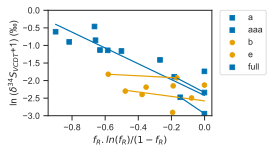

In [1476]:
#Drop outliers in place
#df_sulfate_master.drop(df_sulfate_master.index[9], inplace=True)
#df_sulfate_master.drop(df_sulfate_master.index[2], inplace=True)
#Select treatment e only
df_sulfate_e = df_sulfate_master[(df_sulfate_master.treatment == 'e')]
# Group by replicate
df_group = df_sulfate_master.groupby(['treatment'])

# Define colors
colors = ('#0072B2', '#0072B2','#E69F00','#E69F00','#0072B2')

# Define markers
markers = ['s','s', 'o','o','s']

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    #Calculate trendline  
    z = np.polyfit(data.xaxis_linreg, data.d34S_sulfate, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.xaxis_linreg, p(data.xaxis_linreg), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.xaxis_linreg, data.d34S_sulfate, color=colors[i], marker=markers[i],
              label = group)
    ax.set_xlabel('$f_{R}.ln (f_{R})/(1-f_{R})$')
    ax.set_ylabel('ln ($\delta{}^{34}S_{VCDT}$+1) (‰)')
    ax.set_ylim(-3,0)

#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/ctepwt_fr_sulfate_dark.pdf', bbox_inches='tight')